In [1]:
# import lsst.summit.extras

In [2]:
# lsst.summit.__file__

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from lsst.summit.extras.plotting.psfPlotting import makeAzElPlot, makeTableFromSourceCatalogs, makeFocalPlanePlot, makeEquatorialPlot
from lsst.obs.lsst import LsstComCam, LsstCam
import matplotlib.pyplot as plt

In [5]:
from lsst.daf.butler import Butler

Stuff to load simulations

In [40]:
import sys
# sys.path.append("../../notebooks/")
sys.path.append("/sdf/data/rubin/shared/image_quality/imsim/notebooks/")                #file with convertion between seqnum and collection
from collection_dictionary_shared import collection_dictionary

In [41]:
folder = '/sdf/data/rubin/shared/image_quality/imsim/'
#Define the butler data configuration and collection (una tantum )
config = folder+'repo'
seqnum_base = 5023071800000
collection_dict = collection_dictionary()

In [60]:
seqnum = 124
visitid_complete = seqnum+seqnum_base
collection = collection_dict[visitid_complete]
collection

'pipetask_output/20241104T132752Z'

In [61]:
# collections=["pipetask_output/20241023T144439Z"] #119
# collections=["pipetask_output/20241016T043201Z"] #117
# collections =['pipetask_output/20241104T125942Z'] #121
# collections = ['pipetask_output/20241104T130844Z'] #122
# collections = ['pipetask_output/20241104T131817Z'] #123
# collections = ['pipetask_output/20241104T132752Z']  #124
# collections = ['pipetask_output/20241104T145401Z' ] #133


In [62]:
butler = Butler(config, collections=collections)

In [63]:
butler.collections.query_info(collections[0], include_summary=True)

[CollectionInfo(name='pipetask_output/20241104T125942Z', type=<CollectionType.RUN: 1>, doc='', children=(), parents=None, dataset_types=frozenset({'src', 'calexp', 'icExpBackground', 'calibrate_metadata', 'packages', 'calibrate_config', 'characterizeImage_config', 'icSrc', 'characterizeImage_log', 'postISRCCD', 'isr_config', 'icExp', 'isr_metadata', 'calibrate_log', 'icSrc_schema', 'src_schema', 'calexpBackground', 'isr_log', 'characterizeImage_metadata'}))]

In [64]:
registry = butler.registry

In [65]:
# for dt in sorted(registry.queryDatasetTypes()):
#     print(dt)

In [66]:
postisr = list(registry.queryDatasets('icSrc', collections=collections, detector=90))
postisr
#exposure_ids = np.array([data.dataId['exposure'] for data in postisr])
# exposure_ids

[DatasetRef(DatasetType('icSrc', {band, instrument, detector, physical_filter, visit}, SourceCatalog), {instrument: 'LSSTCam', detector: 90, visit: 5023071800121, band: 'r', physical_filter: 'r_57'}, run='pipetask_output/20241104T125942Z', id=a2554f72-0fd8-495c-9ea5-88fe78f5c9fc)]

In [67]:
icSrcs = {}
# visit_id=5023071800119
# visit_id=5023071800117
visit_id=postisr[0].dataId['visit']
# visit_id=5023071800121


for i in range(189):
    try:
        icSrcs[i] = butler.get("icSrc", dataId={"visit":visit_id, "detector":i})
    except:
        continue
visitInfo = butler.get("postISRCCD.visitInfo", dataId={"exposure":visit_id, "detector":90})
table = makeTableFromSourceCatalogs(icSrcs, visitInfo)

In [58]:
camera = LsstCam().getCamera()

ORGINAL for Rubin TV

In [15]:
# butler = Butler(
#     "embargo", 
#     # collections=["LSSTComCam/quickLook"], 
#     collections=["LSSTComCam/nightlyValidation"], 
#     instrument="LSSTComCam"
# )
# camera = LsstComCam().getCamera()

In [16]:
# dayObs = 20241106 #20241029 #20241028
# seqNum = 251      #33       #10
# visit_id = int(f"{dayObs}{seqNum:05d}")

In [17]:
# icSrcs = {}
# for i in range(9):
#     icSrcs[i] = butler.get("icSrc", dataId={"visit":visit_id, "detector":i})
# visitInfo = butler.get("postISRCCD.visitInfo", dataId={"exposure":visit_id, "detector":4})
# table = makeTableFromSourceCatalogs(icSrcs, visitInfo)

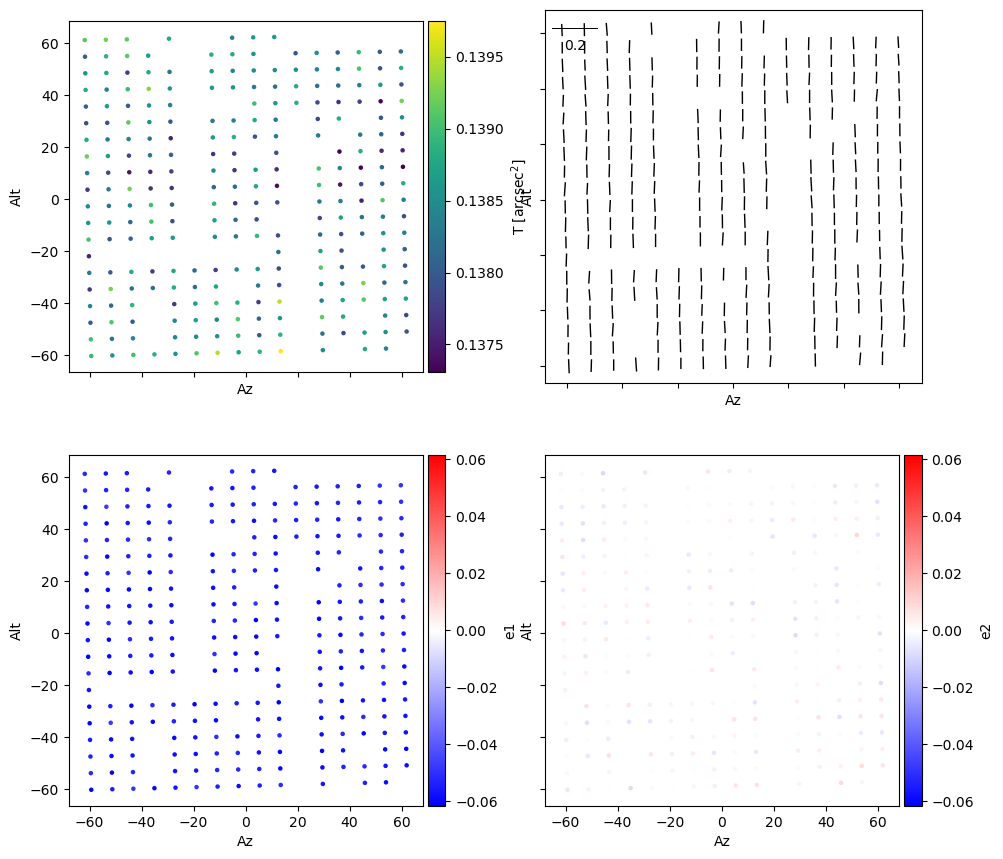

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeAzElPlot(fig, axes, table, camera)
plt.show()

In [17]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeFocalPlanePlot(fig, axes, table, camera)
# plt.show()

In [16]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeEquatorialPlot(fig, axes, table, camera)
# plt.show()